In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

(#2) [Path('/home/ilua/.fastai/data/mnist_png/training'),Path('/home/ilua/.fastai/data/mnist_png/testing')]

In [4]:
num_numbers = len((path/'/home/ilua/.fastai/data/mnist_png/training/').ls())

In [92]:
num_numbers = 10

In [93]:
for number in range(num_numbers):
    image_array = (path/'/home/ilua/.fastai/data/mnist_png/training/{}'.format(number)).ls().sorted()
    current_tensor = [tensor(Image.open(o)) for o in image_array]
    train_x_one = torch.stack(current_tensor).float()/255
    train_y_one = tensor([number]*train_x_one.size(dim=0))
    if number == 0:
        train_x = train_x_one
        train_y = train_y_one
    else:
        train_x = torch.cat([train_x, train_x_one])
        train_y = torch.cat([train_y, train_y_one])
train_x = train_x.view(-1, 28*28) 
print('train_x.shape : ',train_x.shape)
print('train_y.shape : ',train_y.shape)

train_x.shape :  torch.Size([60000, 784])
train_y.shape :  torch.Size([60000])


In [6]:
train_y_onehot = torch.nn.functional.one_hot(train_y, num_classes=10)
print(train_y_onehot)
print(train_y_onehot.shape)

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1]])
torch.Size([60000, 10])


In [8]:
dset = list(zip(train_x, train_y_onehot))
x,y = dset[5000]
x.shape,y

(torch.Size([784]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

***Splitting data to train and validation parts***

In [9]:
from torch.utils.data import random_split
train_subset, val_subset = random_split(dset, [50000, 10000])

In [10]:
x,y = train_subset[10000]
val_subset[8][1]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [11]:
val_subset[8][0].shape

torch.Size([784])

***Creating Dataloader***

In [12]:
dl = DataLoader(train_subset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 10]))

In [13]:
train5samplesX = xb[:5]
train5samplesX

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
train5samplesY = yb[:5]
train5samplesY

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [15]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 10))

In [16]:
bias = init_params(10)

***Just a One row***

In [17]:
(train5samplesX[0]*weights.T).sum() + bias

tensor([ 2.2850,  3.7128,  2.6190,  1.7300,  1.9613,  1.3363,  0.3574,  2.7029, -0.6055,  2.1184], grad_fn=<AddBackward0>)

***Introducing a matrix***

In [18]:
def linear1(xb): return xb@weights + bias
preds = linear1(train5samplesX)
preds

tensor([[ 13.7140,  -7.1461,  -4.6153,  -4.8304,  -3.9931,   1.9154,   7.9000,   4.5809, -13.6448,   7.7113],
        [  6.3873, -11.1138, -16.3354,  -2.3152,  15.7239,  -4.1659,  14.1441,   3.6211,   4.4445,  11.0829],
        [-10.4526, -10.5237,   1.7343, -19.2866,   7.7671,   7.6704,  18.9899,   2.8703,  -2.7446,   4.9299],
        [  0.2623,  -5.6711,  -0.1749,   0.7750,  10.2444,  -8.9311,  13.1438,   1.5010,  15.5694,   0.5869],
        [  6.3304,  -3.8711,  11.0098,  -7.3885,   7.6471,  10.7820,  -4.6661,  -7.3201,  -6.0965,  16.0183]], grad_fn=<AddBackward0>)

In [21]:
predicted_classes = preds.argmax(dim=1)
correct_classes = train5samplesY.argmax(dim=1)
print(predicted_classes, correct_classes)
torch.eq(predicted_classes, correct_classes)


tensor([0, 4, 6, 8, 9]) tensor([6, 7, 0, 4, 6])


tensor([False, False, False, False, False])

In [23]:
import torch
import torch.nn.functional as F

def cross_entropy_loss(outputs, labels):
    labels = labels.argmax(dim=1)
    # Apply log softmax on outputs
    outputs = F.log_softmax(outputs, dim=1)

    # Pick the values corresponding to the labels
    outputs = outputs[range(outputs.shape[0]), labels]
    return -torch.mean(outputs)

In [24]:
outputs = F.log_softmax(preds, dim=1)

In [25]:
train5samplesY.argmax(dim=1)

tensor([6, 7, 0, 4, 6])

In [26]:
outputs[range(5),train5samplesY.argmax(dim=1)]

tensor([ -5.8196, -12.2982, -29.4426,  -5.4143, -20.6966], grad_fn=<IndexBackward0>)

In [27]:
preds.shape, train5samplesY.shape

(torch.Size([5, 10]), torch.Size([5, 10]))

In [28]:
cross_entropy_loss(preds, train5samplesY)

tensor(14.7342, grad_fn=<NegBackward0>)

In [29]:
weights

tensor([[ 1.3783,  1.6179, -0.2142,  ...,  1.5158, -1.6900, -1.2508],
        [ 0.2404,  1.4172, -1.5082,  ...,  1.4478, -1.0887,  0.2604],
        [-0.1127,  0.2966, -0.7654,  ..., -0.6982, -1.3256,  1.1696],
        ...,
        [ 0.9060,  0.0317,  0.5278,  ...,  0.7861, -0.8612, -0.0091],
        [ 0.6330, -1.0880, -0.7266,  ..., -1.2868, -0.2188,  1.2752],
        [ 1.5765, -1.1352,  1.0076,  ...,  0.2015,  0.2746,  0.3140]], requires_grad=True)

In [ ]:
with torch.no_grad(): weights *= 1.0002

In [30]:
weights

tensor([[ 1.3783,  1.6179, -0.2142,  ...,  1.5158, -1.6900, -1.2508],
        [ 0.2404,  1.4172, -1.5082,  ...,  1.4478, -1.0887,  0.2604],
        [-0.1127,  0.2966, -0.7654,  ..., -0.6982, -1.3256,  1.1696],
        ...,
        [ 0.9060,  0.0317,  0.5278,  ...,  0.7861, -0.8612, -0.0091],
        [ 0.6330, -1.0880, -0.7266,  ..., -1.2868, -0.2188,  1.2752],
        [ 1.5765, -1.1352,  1.0076,  ...,  0.2015,  0.2746,  0.3140]], requires_grad=True)

In [31]:
preds = linear1(train5samplesX)
preds

tensor([[ 13.7140,  -7.1461,  -4.6153,  -4.8304,  -3.9931,   1.9154,   7.9000,   4.5809, -13.6448,   7.7113],
        [  6.3873, -11.1138, -16.3354,  -2.3152,  15.7239,  -4.1659,  14.1441,   3.6211,   4.4445,  11.0829],
        [-10.4526, -10.5237,   1.7343, -19.2866,   7.7671,   7.6704,  18.9899,   2.8703,  -2.7446,   4.9299],
        [  0.2623,  -5.6711,  -0.1749,   0.7750,  10.2444,  -8.9311,  13.1438,   1.5010,  15.5694,   0.5869],
        [  6.3304,  -3.8711,  11.0098,  -7.3885,   7.6471,  10.7820,  -4.6661,  -7.3201,  -6.0965,  16.0183]], grad_fn=<AddBackward0>)

In [ ]:
# lr = 0.02
# for x,y in dl:
#     pred = linear1(x)
#     loss = cross_entropy_loss(pred, y)
#     loss.backward()
#     parameters -= parameters.grad * lr

In [32]:
dl = DataLoader(train_subset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 10]))

In [ ]:
# weights = init_params((28*28,1))
# bias = init_params(1)

In [33]:
valid_dl = DataLoader(val_subset, batch_size=256)

In [34]:
batch = xb[:8]
batch.shape

torch.Size([8, 784])

In [35]:
preds = linear1(batch)
preds

tensor([[ 13.7140,  -7.1461,  -4.6153,  -4.8304,  -3.9931,   1.9154,   7.9000,   4.5809, -13.6448,   7.7113],
        [  6.3873, -11.1138, -16.3354,  -2.3152,  15.7239,  -4.1659,  14.1441,   3.6211,   4.4445,  11.0829],
        [-10.4526, -10.5237,   1.7343, -19.2866,   7.7671,   7.6704,  18.9899,   2.8703,  -2.7446,   4.9299],
        [  0.2623,  -5.6711,  -0.1749,   0.7750,  10.2444,  -8.9311,  13.1438,   1.5010,  15.5694,   0.5869],
        [  6.3304,  -3.8711,  11.0098,  -7.3885,   7.6471,  10.7820,  -4.6661,  -7.3201,  -6.0965,  16.0183],
        [  3.2634,  -4.7596,  -5.1665,  -3.5301,   4.4131,  -4.0056,   1.8292,  -4.3071,  -0.0903,  -4.5500],
        [ -6.8297,  -8.0538,   6.8736,  10.1589,  12.7683,   4.9916,   3.7458,   9.0290,   8.4154,  16.6956],
        [ -3.2268,  -7.8193,  -6.4320,   1.1249,   2.3179,  -5.9347,  -3.7483,  10.3284,   6.7205,   2.8247]], grad_fn=<AddBackward0>)

In [38]:
loss = cross_entropy_loss(preds, yb[:4])
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [8], [4]

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [36]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(preds, yb)
    loss.backward()

In [37]:
calc_grad(batch, yb[:4], linear1)
weights.grad.mean(),bias.grad

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [8], [4]

In [39]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [40]:
def accuracy(preds, corrects):
    predicted_classes = preds.argmax(dim=1)
    correct_classes = corrects.argmax(dim=1)
    torch.eq(predicted_classes, correct_classes)

In [41]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    predicted_classes = preds.argmax(dim=1)
    correct_classes = yb.argmax(dim=1)
    # print(predicted_classes, correct_classes)
    correct = torch.eq(predicted_classes, correct_classes)
    # print(correct)
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), yb[:8])

In [42]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [43]:
lr = 1.
params = weights,bias

In [44]:
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.8015

In [45]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8317 0.8423 0.8522 0.8567 0.8622 0.8663 0.8686 0.8715 0.8729 0.8756 0.8768 0.878 0.8795 0.8809 0.8831 0.8832 0.8841 0.8854 0.887 0.8887 

***Creating an Optimizer***

In [46]:
linear_model = nn.Linear(28*28,10)

In [47]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [48]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [49]:
opt = BasicOptim(linear_model.parameters(), lr)

In [50]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [51]:
validate_epoch(linear_model)

0.1211

In [52]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [53]:
train_model(linear_model, 20)

0.8964 0.9043 0.9098 0.9112 0.912 0.9122 0.9128 0.9137 0.9146 0.9152 0.9157 0.9156 0.9158 0.9159 0.9166 0.9165 0.9168 0.9167 0.9163 0.9165 

In [54]:
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.8974 0.9054 0.9103 0.9111 0.9115 0.9115 0.9127 0.9137 0.9149 0.9157 0.9158 0.9158 0.9156 0.916 0.916 0.9162 0.9162 0.9161 0.9163 0.9159 

In [55]:
dls = DataLoaders(dl, valid_dl)

In [56]:
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=cross_entropy_loss, metrics=batch_accuracy)

In [57]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.363868,0.360689,0.898400,00:00
1,0.314931,0.335654,0.906800,00:00
2,0.299560,0.324676,0.910900,00:00
3,0.290919,0.318396,0.911500,00:00
4,0.285035,0.314316,0.912300,00:00
5,0.280638,0.311462,0.912700,00:00
6,0.277159,0.309367,0.913900,00:00
7,0.274299,0.307777,0.914900,00:00
8,0.271882,0.306539,0.916000,00:00
9,0.269795,0.305558,0.916300,00:00


***Adding a Nonlinearity***

In [58]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [59]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,10))
b2 = init_params(10)

In [60]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)

In [61]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=cross_entropy_loss, metrics=batch_accuracy)

In [62]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.556007,0.449189,0.879400,00:00
1,0.361340,0.360914,0.899300,00:00
2,0.316797,0.329694,0.909000,00:00
3,0.292306,0.309405,0.914600,00:00
4,0.273474,0.291876,0.919300,00:00
5,0.257340,0.276457,0.923500,00:00
6,0.243743,0.263445,0.926100,00:00
7,0.232303,0.252475,0.929200,00:00
8,0.222193,0.242489,0.932500,00:00
9,0.213138,0.233997,0.933700,00:00


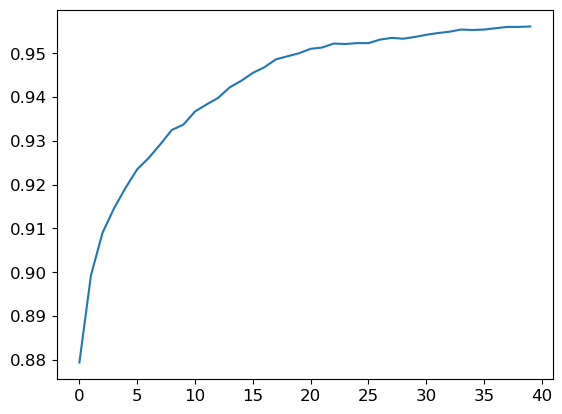

In [63]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [64]:
learn.recorder.values[-1][2]

0.9560999870300293

***Test a model***

In [73]:
testimg = (path/'/home/ilua/.fastai/data/mnist_png/testing/2').ls().sorted()

In [74]:
testimg

(#1032) [Path('/home/ilua/.fastai/data/mnist_png/testing/2/1.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1002.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1016.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1031.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1036.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1049.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1050.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1053.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/1056.png'),Path('/home/ilua/.fastai/data/mnist_png/testing/2/106.png')...]

In [75]:
img = testimg[3]
im3 = Image.open(img)
im3

In [76]:
im3array = tensor(im3)

In [77]:
item = im3array.view(28*28)
item.shape

torch.Size([784])

In [78]:
out = simple_net(item.float())

In [79]:
predicted_class = torch.argmax(out)

In [80]:
predicted_class

tensor(2)

In [81]:
img = (path/'/home/ilua/.fastai/data/mnist_png/testing/8').ls()[66]
im3 = Image.open(img)
display(im3)
item = tensor(im3).view(28*28)
predicted_class = torch.argmax(simple_net(item.float()))
predicted_class

tensor(8)

In [96]:
from random import random
for sample in range(12):
    sample = int(sample%9)
    img = (path/'/home/ilua/.fastai/data/mnist_png/testing/{}'.format(sample)).ls()[int(random()*100)]
    im3 = Image.open(img)
    display(im3)
    item = tensor(im3).view(28*28)
    predicted_class = torch.argmax(simple_net(item.float()))
    print(predicted_class)

tensor(0)


tensor(1)


tensor(2)


tensor(3)


tensor(4)


tensor(5)


tensor(6)


tensor(7)


tensor(8)


tensor(0)


tensor(1)


tensor(2)


***Making a Confusion matrix***

In [86]:
for number in range(num_numbers):
    image_array = (path/'/home/ilua/.fastai/data/mnist_png/testing/{}'.format(number)).ls().sorted()
    current_tensor = [tensor(Image.open(o)) for o in image_array]
    test_x_one = torch.stack(current_tensor).float()/255
    test_y_one = tensor([number]*test_x_one.size(dim=0))
    if number == 0:
        test_x = test_x_one
        test_y = test_y_one
    else:
        test_x = torch.cat([test_x, test_x_one])
        test_y  = torch.cat([test_y, test_y_one])
test_x = test_x.view(-1, 28*28) 
print('train_x.shape : ',test_x.shape)
print('train_y.shape : ',test_y.shape)
# test_y_onehot = torch.nn.functional.one_hot(test_y, num_classes=10) //shouldn't be One-hot for testing
# print(test_y_onehot)
# print(test_y_onehot.shape)

train_x.shape :  torch.Size([10000, 784])
train_y.shape :  torch.Size([10000])


In [87]:
dsettest = list(zip(test_x, test_y))
x,y = dset[5000]
x.shape,y

(torch.Size([784]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [88]:
dltest = DataLoader(dsettest, batch_size=256)

In [89]:
from sklearn.metrics import confusion_matrix
model = simple_net
# Assume 'model' is your trained model and 'test_loader' is your DataLoader for test data
# Get all the predictions for the test data
all_preds = []
all_labels = []
for images, labels in dltest:
    preds = model(images)
    # print(preds)
    all_preds.append(preds.argmax(dim=1).numpy())
    all_labels.append(labels.numpy())

# Flatten the list of predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)
print(conf_mat)

[[ 964    0    0    2    1    3    7    1    2    0]
 [   0 1118    5    1    0    1    2    2    6    0]
 [   5    1  985    5    5    3    6    7   15    0]
 [   0    2   17  948    0   14    1   11   15    2]
 [   1    0    3    0  955    1    8    2    2   10]
 [   2    0    2    7    2  853    9    1   11    5]
 [   7    3    3    1    4    6  928    0    6    0]
 [   1    5   13    3    2    2    0  994    2    6]
 [   2    2    4    9    4    5    5    6  935    2]
 [   6    6    0    7   26    6    2    9    9  938]]
